#### detection -> crop predicted images

참고) https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.BaseTensor.numpy

#### color extraction
* https://github.com/CairX/extract-colors-py?tab=readme-ov-file#id14
* https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
* https://webcolors.readthedocs.io/en/latest/contents.html
* https://matplotlib.org/stable/users/explain/colors/colors.html
* https://xkcd.com/color/rgb/


In [1]:
import os
import extcolors
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.colors as mcolors
import pandas as pd

from ultralytics import YOLO

import torch
from torchvision.transforms import v2 # pytorch

In [2]:
# def ################################################################################

# detection과 object부분 크롭
def crop_imgs(img_path, custom_model):
    model = YOLO(custom_model)  # load a pretrained YOLOv8n detection model

    # model.train(data='coco128.yaml', epochs=3)  # train the model
    model.predict(img_path, save_crop=True)  # predict on an image 
    # 추가 파라미터: save_txt=True, show=True 사용 가능

    # # Extract bounding boxes, classes, names, and confidences
    # boxes = results[0].boxes.xyxy.tolist()
    # classes = results[0].boxes.cls.tolist()
    # names = results[0].names
    # confidences = results[0].boxes.conf.tolist()

    # # Iterate through the results
    # for box, cls, conf in zip(boxes, classes, confidences):
    #     x1, y1, x2, y2 = box
    #     confidence = conf
    #     detected_class = cls
    #     name = names[int(cls)]


# XKCD COLORS info를 df로 생성
def colors_df():
  global df
  df = pd.DataFrame(columns=['name','red','green','blue'])
  for color_name, color_hex in mcolors.XKCD_COLORS.items():
      r, g, b = mcolors.to_rgb(color_hex)
      df = pd.concat([df, pd.DataFrame({'name':[color_name], 'red':[r], 'green':[g], 'blue':[b]})], ignore_index= True)
  return df

# 가까운 색상명
def closest_color(rgb):
  differences = {}
  for color_name, color_hex in mcolors.XKCD_COLORS.items(): # mcolors.CSS4_COLORS mcolors.XKCD_COLORS
    r, g, b = mcolors.to_rgb(color_hex)

    differences[sum([(r*255-rgb[0])**2,
                    (g*255-rgb[1])**2,
                    (b*255-rgb[2])**2])] = color_name
    
  return differences[min(differences.keys())]



# 이미지 색상명 추출
def find_colorname(item, croppedfolder):
  top_img = os.listdir(croppedfolder + item)[0]
  top_img_path = croppedfolder + item + '/' + top_img

  org_img = Image.open(top_img_path)

  # 원본 이미지 사이즈 구하기
  org_img_size = v2.functional.get_size(org_img)

  # 가로, 세로 중 짧은 쪽의 80% 길이로 만들기
  size_80 = min(org_img_size[0], org_img_size[1]) * 0.8
  centercrop = v2.CenterCrop(size_80)
  img_size80 = centercrop(org_img)

  # plt.imshow(img_size80)

  # 색상 추출
  colors, pixel_count = extcolors.extract_from_image(img_size80)

  # output
  clothes_color = closest_color(colors[0][0])

  # check the colors
  # rgb_list = [colors[0][0]] # 가장 많은 컬러
  # one_px = np.array(rgb_list)[np.newaxis, :, :]

  # plt.imshow(np.array(one_px))
  # plt.axis('off')
  # plt.show()
  return clothes_color


# 파일명 없으면 생성
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)


In [ ]:
# run ###############################################

# 색상, 옷 카테고리 결과 담을 df
result = pd.DataFrame(columns=['img_path','top_category','top_color','bottom_category','bottom_color'])

# source info
image_folder = '.\\images\\'
custom_model = '..\\object_detection\\runs\\detect\\datav5result\\weights\\best.pt'

for img in os.listdir(image_folder):
    image_source = image_folder + img

    try:
        # object에 맞게 이미지 크롭
        crop_imgs(image_source, custom_model)

        # 크롭된 이미지의 위치
        cropped_folder = r'./runs/detect/predict/crops/'
        for item in os.listdir(cropped_folder): # 해당 폴더 내 모든 파일 및 폴더 추출
            # item: 옷 카테고리명
            color = find_colorname(item, cropped_folder)
            if item in ['shirt','sweater','mtm','hoodies','longsleeve','shortsleeve','jacket','blazer','padding','zipup','cardigan','coat']:
                top = {'item':item, 'color':color}
            else: # skirt, denim pants, cotton pants, trainingpants, slacks, short pants
                bottom = {'item':item, 'color':color}

        # result df에 추가
        result = pd.concat([result, pd.DataFrame({'img_path':[image_source],'top_category':[top.get('item')],
                                                'top_color':[top.get('color')],'bottom_category':[bottom.get('item')],
                                                'bottom_color':[bottom.get('color')]})], ignore_index= True)
            
        # cropped_folder 삭제
        import shutil
        shutil.rmtree(r'./runs/')
    except:
        continue



In [5]:
result.to_csv('./result.csv',index=False, encoding='utf-8')

#### color clustering: dbscan (best)

In [34]:
colors_df()

# df 행 셔플
df = df.sample(frac=1)

In [88]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.1
               , min_samples=4)

data = df.drop(columns='name')

model.fit(data)

df['cluster'] = model.fit_predict(data)

In [89]:
len(df['cluster'].unique())

40

In [90]:
df['cluster'].value_counts()

 0     235
-1     166
 2     136
 5      47
 1      45
 14     28
 13     24
 7      23
 15     19
 3      15
 4      15
 12     14
 6      14
 11     13
 16     12
 20     11
 22     10
 23      9
 25      8
 27      8
 17      8
 21      7
 24      6
 38      5
 34      5
 31      5
 18      5
 28      5
 36      5
 8       5
 9       5
 37      4
 26      4
 32      4
 29      4
 19      4
 35      4
 33      4
 10      4
 30      4
Name: cluster, dtype: int64

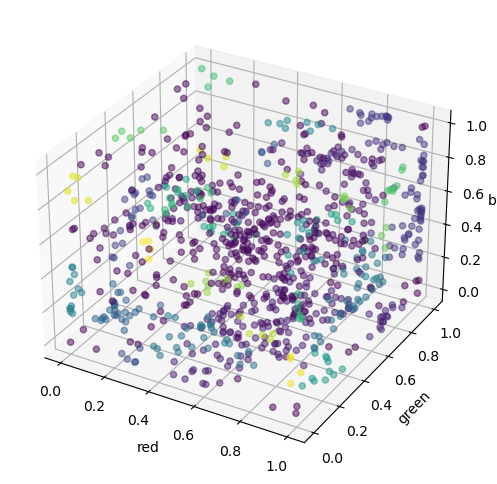

In [91]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['red'],df['green'],df['blue'],c=df['cluster'], alpha=0.5)
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')
plt.show()

In [92]:
# eps=0.1, min_samples=2
# eps=0.1, min_samples=5
# eps=0.1, min_samples=10 
# eps=0.09, min_samples=10
# eps=0.09, min_samples=3 (this)
df.to_csv('./cluster.csv',encoding='utf-8',index=False)

In [93]:
cluster= pd.read_csv('./cluster.csv').drop(columns=['red','blue','green'])
result = pd.read_csv('./result.csv')

result = pd.merge(result, cluster, how='left', left_on='top_color', right_on='name').drop(columns='name').rename(columns={'cluster':'top_color_cluster'})
result = pd.merge(result, cluster, how='left', left_on='bottom_color', right_on='name').drop(columns='name').rename(columns={'cluster':'bottom_color_cluster'})

In [98]:
result.to_csv('./result_colorclustering.csv',encoding='utf-8',index=False)

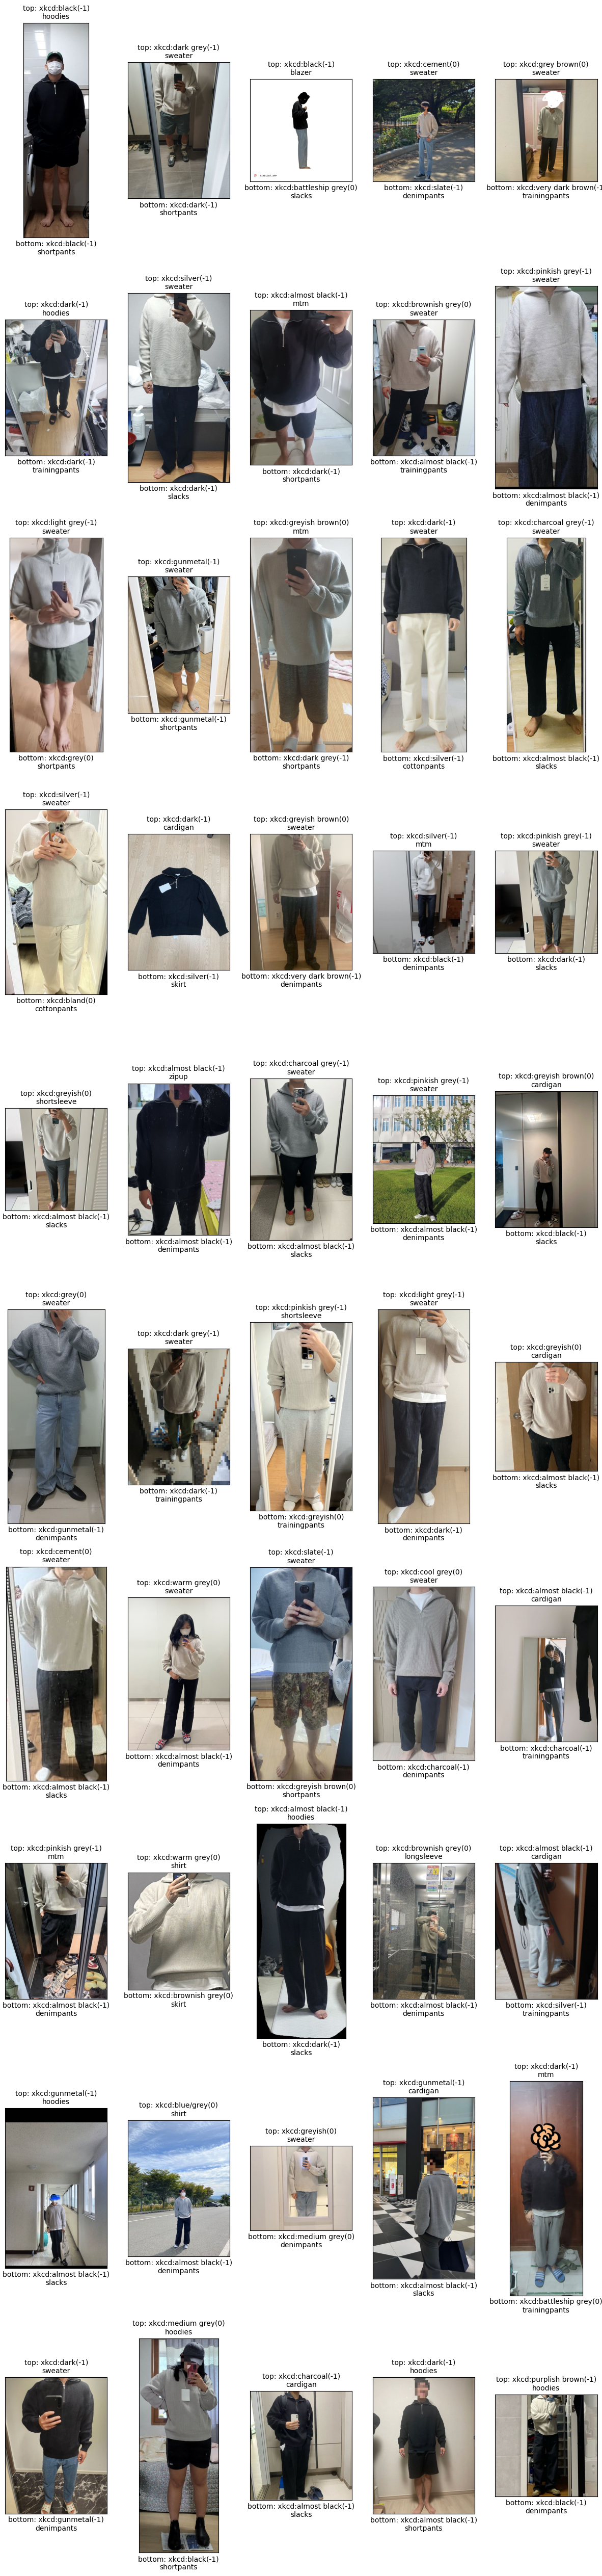

In [95]:
from PIL import Image
import matplotlib.pyplot as plt

# // %matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 130.0)



# struct is  [10, 5]
rows = 20
columns = 5

for i in range(len(result[:50])) : 
    image = Image.open(result['img_path'][i])
    image_index = i + 1     # image index 
    ttitle = f"top: {result['top_color'][i]}({result['top_color_cluster'][i]})\n{result['top_category'][i]}" # image title
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(ttitle, fontsize=10)   # title 
    # // plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.xlabel(f"bottom: {result['bottom_color'][i]}({result['bottom_color_cluster'][i]})\n{result['bottom_category'][i]}", fontsize=10)
    plt.imshow(image)

plt.show()

In [ ]:
# 어떤 카테고리 + 색감이 가장 많았는지
# 색감별로 보여주기
# 카테고리별 보여주기

In [96]:
# 어떤 색상이 많은지
result[['top_color','bottom_color']].value_counts()

top_color           bottom_color     
xkcd:almost black   xkcd:almost black    18
xkcd:medium grey    xkcd:almost black    12
xkcd:gunmetal       xkcd:almost black    12
xkcd:dark           xkcd:dark            10
xkcd:charcoal grey  xkcd:almost black    10
                                         ..
xkcd:greyish        xkcd:cement           1
                    xkcd:charcoal         1
                    xkcd:dark brown       1
                    xkcd:grey             1
xkcd:white          xkcd:dark             1
Length: 250, dtype: int64

In [97]:
# 어떤 색상 cluster가 많은지
result[['top_color_cluster','bottom_color_cluster']].value_counts()

top_color_cluster  bottom_color_cluster
-1                 -1                      240
 0                 -1                      129
-1                  0                       42
 0                  0                       24
 16                -1                        3
 5                 -1                        3
 0                  16                       3
-1                  16                       2
 1                  0                        1
 2                  2                        1
                   -1                        1
 0                  2                        1
 1                 -1                        1
-1                  17                       1
                    15                       1
                    2                        1
 32                -1                        1
dtype: int64

In [99]:
# 어떤 카테고리가 가장 많은지
result[['top_category','bottom_category']].value_counts()

top_category  bottom_category
sweater       denimpants         84
              slacks             82
              cottonpants        28
cardigan      slacks             25
sweater       trainingpants      23
mtm           slacks             20
              denimpants         18
sweater       shortpants         15
mtm           trainingpants      12
hoodies       denimpants         12
cardigan      denimpants         10
              trainingpants      10
jacket        denimpants          8
mtm           cottonpants         8
hoodies       slacks              8
shirt         slacks              8
coat          slacks              7
cardigan      cottonpants         6
shirt         denimpants          5
coat          denimpants          5
padding       slacks              4
mtm           shortpants          4
padding       denimpants          4
jacket        slacks              3
padding       trainingpants       3
              cottonpants         3
longsleeve    slacks              